Размер данных: (569, 30)
Распределение истинных меток:
 Доброкачественная    357
Злокачественная      212
Name: count, dtype: int64


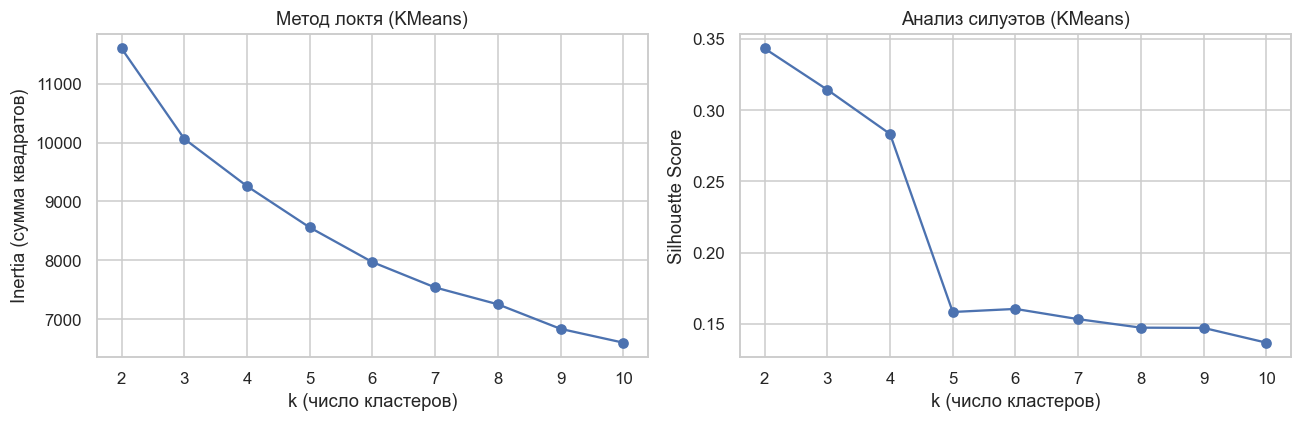

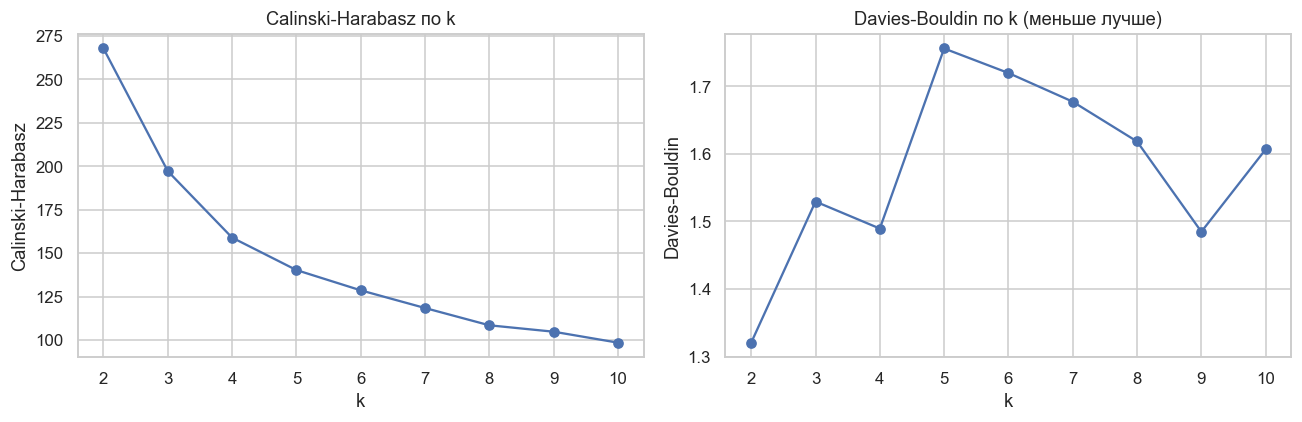

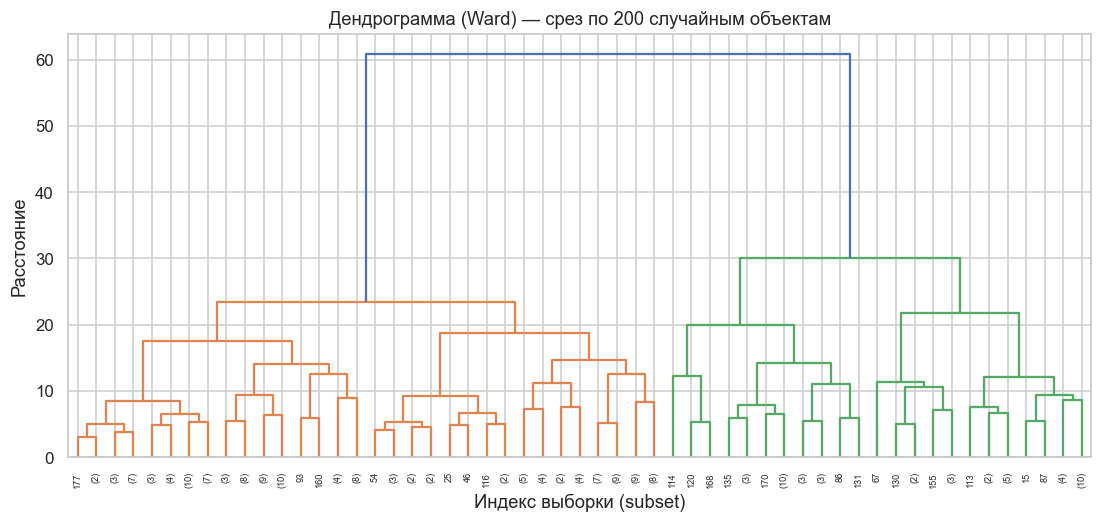

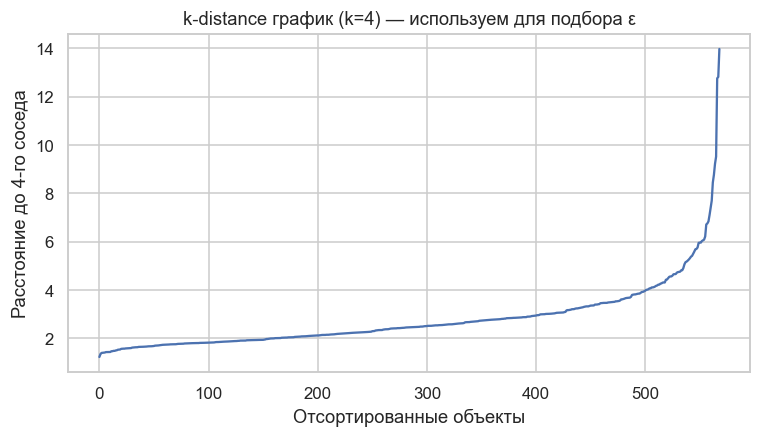

,Алгоритм,Число кластеров,Время (с),Silhouette,Calinski,Davies-Bouldin,ARI
0,Agglomerative (complete),2,0.0000,0.6607,27.8727,0.4497,0.0048
1,Agglomerative (single),2,0.0090,0.6607,27.8727,0.4497,0.0048
2,Agglomerative (average),2,0.0094,0.6340,32.4822,0.6799,0.0073
3,KMeans (k=2),2,0.1084,0.3450,267.6964,1.3123,0.6707
4,Agglomerative (ward),2,0.0125,0.3394,248.6288,1.3700,0.5750
5,KMeans (k=3),3,0.1283,0.3144,197.1140,1.5294,0.5107
6,"DBSCAN (eps=0.3, ms=5)",0,0.0099,NaN,NaN,NaN,NaN
7,"DBSCAN (eps=0.5, ms=5)",0,0.0063,NaN,NaN,NaN,NaN
8,"DBSCAN (eps=0.8, ms=5)",0,0.0053,NaN,NaN,NaN,NaN
9,"DBSCAN (eps=1.0, ms=5)",0,0.0067,NaN,NaN,NaN,NaN


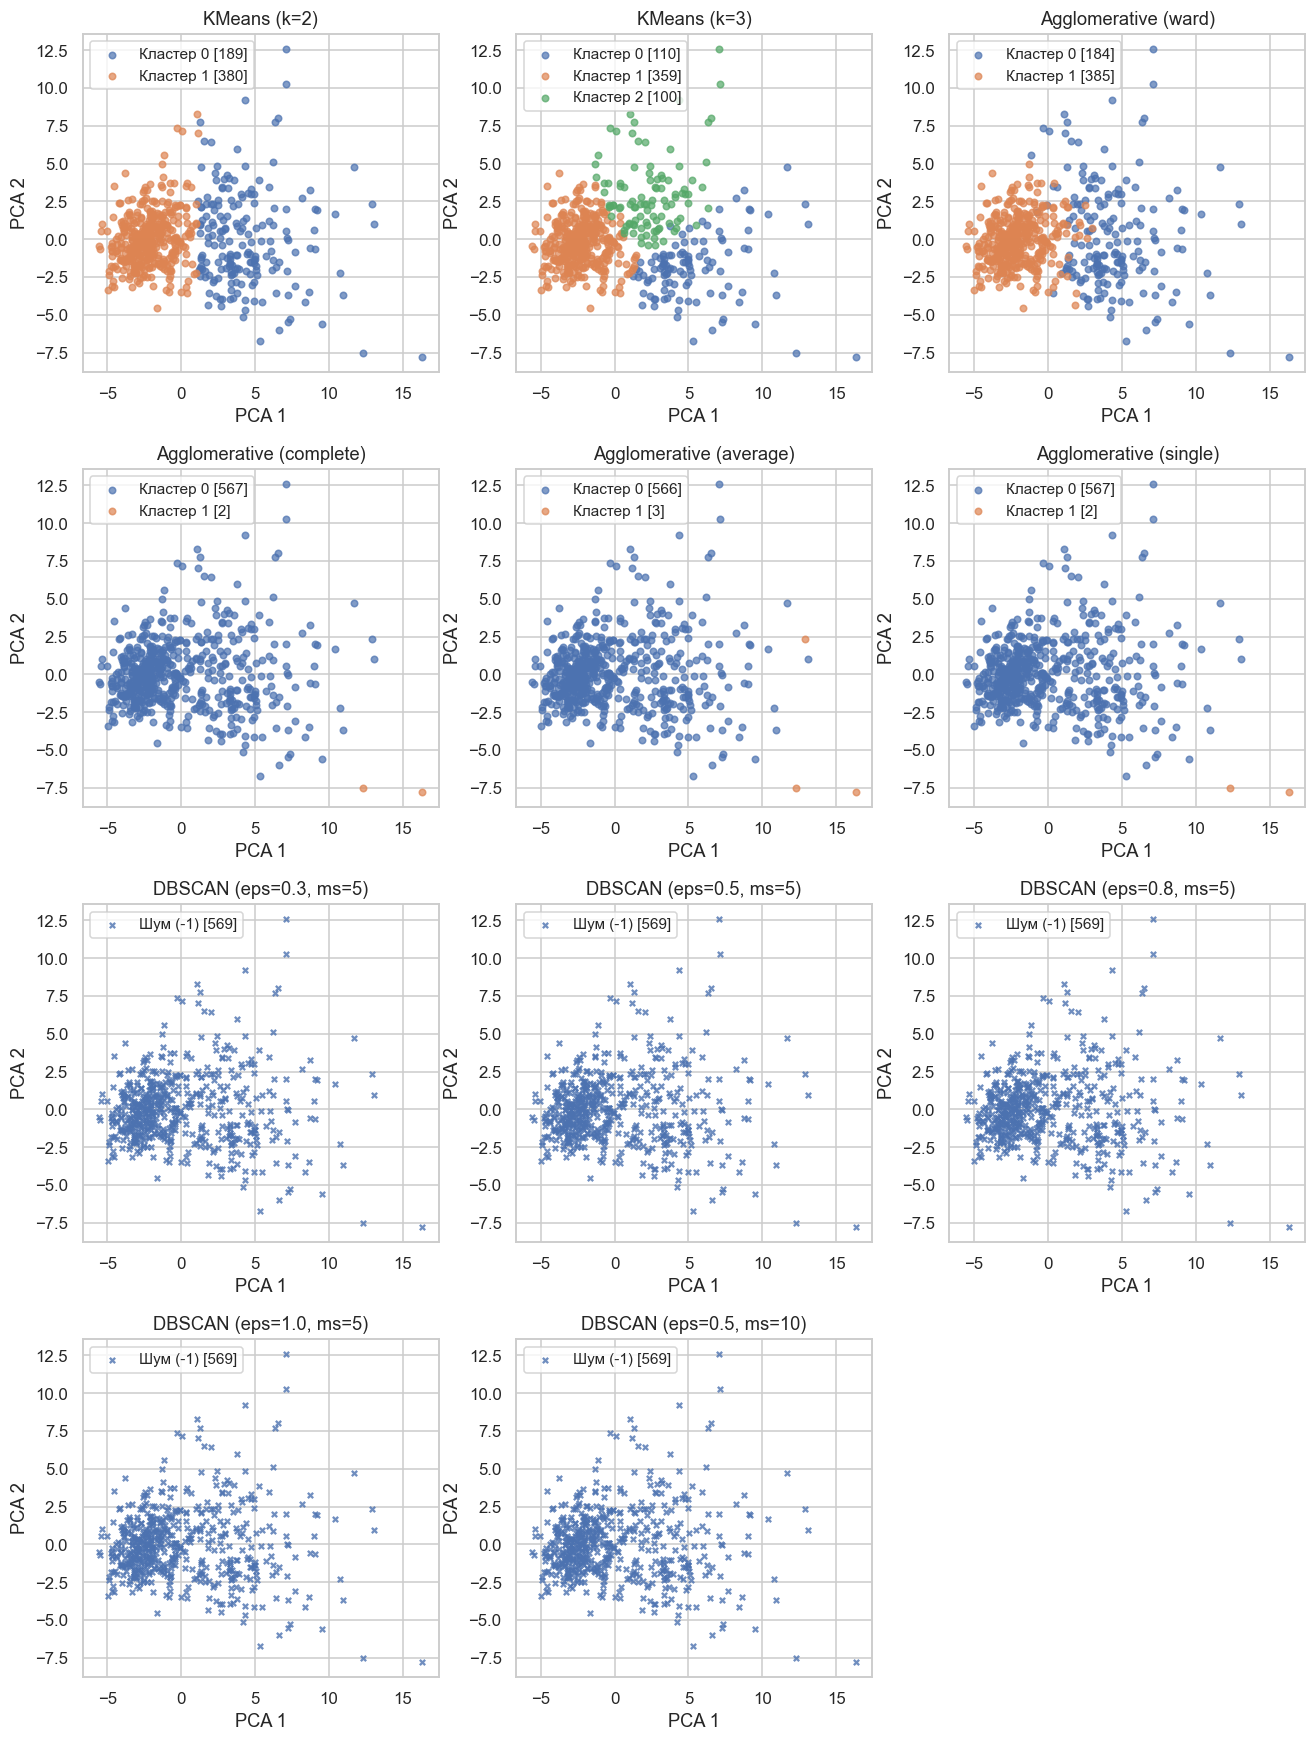

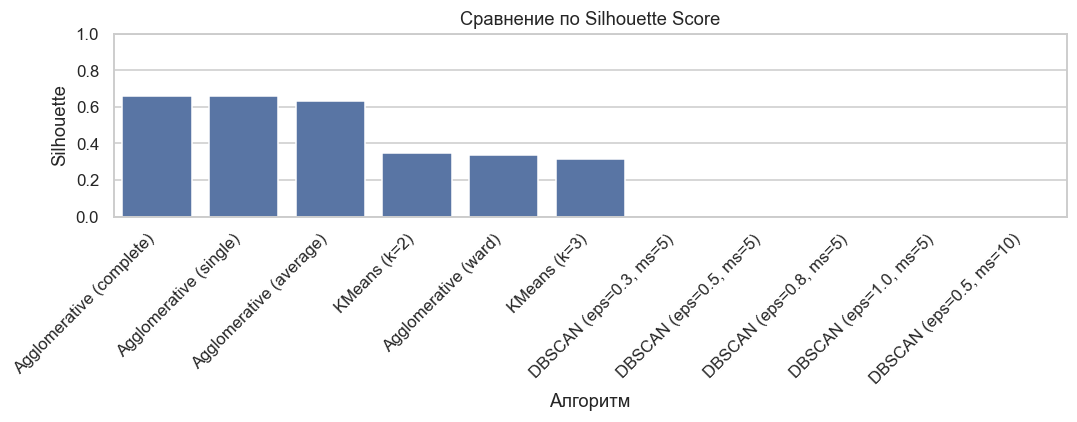

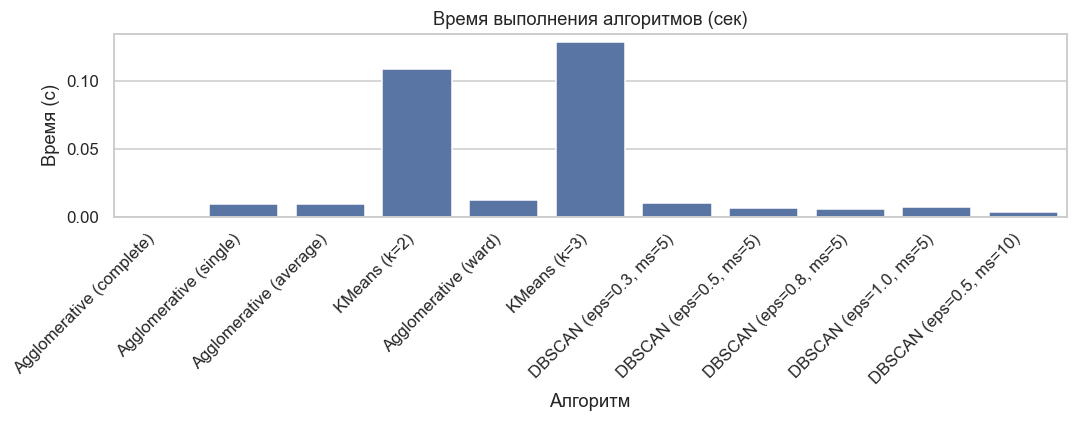


Краткие выводы и рекомендации:
- Для Breast Cancer датасет естественно разделяется на 2 группы (доброкачественные/злокачественные), поэтому KMeans с k=2 и иерархия с n_clusters=2 дают осмысленные разбиения.
- Silhouette/Calinski/Davies дают количественные показатели для сравнения; ARI показывает согласованность кластеров с истинными метками.
- DBSCAN может выделять шум (label=-1) — полезно, если нужны выбросы, но чувствителен к выбору eps/min_samples.
- Дендрограмма помогает понять иерархическую структуру, но для полного набора данных лучше использовать срезы (subsampling).
- Если нужно — могу подобрать eps для DBSCAN автоматически (по k-distance) и/или показать 3D визуализацию PCA.


In [1]:
# Лабораторная работа №4 — Сравнение методов кластеризации (Breast Cancer Wisconsin)
# Запуск в Jupyter/Colab рекомендован. Все подписи на русском языке.

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score
from sklearn.neighbors import NearestNeighbors

from scipy.cluster.hierarchy import linkage, dendrogram

sns.set(style='whitegrid', font_scale=1.0)
plt.rcParams['figure.dpi'] = 110

# -----------------------
# 1) Загрузка и предобработка данных
# -----------------------
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y_true = pd.Series(data.target).map({0: 'Злокачественная', 1: 'Доброкачественная'})  # истинные метки (для ARI)

print("Размер данных:", X.shape)
print("Распределение истинных меток:\n", y_true.value_counts())

# Масштабирование
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA для 2D/3D визуализации
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X_scaled)

# -----------------------
# Утилиты: оценка, время, таблицы
# -----------------------
def evaluate_clustering(labels, X_scaled, X_pca2, y_true, name, time_fit=0):
    # Если кластер всего один или все -1 (DBSCAN без кластеров), вернуть NaN
    unique_labels = np.unique(labels)
    n_clusters = len([lab for lab in unique_labels if lab != -1])
    res = {
        'Алгоритм': name,
        'Число кластеров': n_clusters,
        'Время (с)': round(time_fit, 4)
    }
    if n_clusters <= 1:
        res.update({'Silhouette': np.nan, 'Calinski': np.nan, 'Davies-Bouldin': np.nan, 'ARI': np.nan})
        return res
    # Метрики
    res['Silhouette'] = round(silhouette_score(X_scaled, labels), 4)
    res['Calinski'] = round(calinski_harabasz_score(X_scaled, labels), 4)
    res['Davies-Bouldin'] = round(davies_bouldin_score(X_scaled, labels), 4)
    # ARI: сравнение с истинными метками (числовые)
    # преобразуем y_true в 0/1
    y_num = data.target  # 0/1 уже
    # labels may be arbitrary integers; adjust to numeric array
    # For ARI we can use labels directly (where -1 is treated as cluster)
    res['ARI'] = round(adjusted_rand_score(y_num, labels), 4)
    return res

# -----------------------
# 2) Определение оптимального числа кластеров для KMeans
#    - метод локтя (inertia)
#    - Silhouette
# -----------------------
Ks = list(range(2, 11))
inertias = []
silhouettes = []

for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, km.labels_))

# Графики локтя и силуэта
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].plot(Ks, inertias, '-o')
axes[0].set_xlabel('k (число кластеров)')
axes[0].set_ylabel('Inertia (сумма квадратов)')
axes[0].set_title('Метод локтя (KMeans)')

axes[1].plot(Ks, silhouettes, '-o')
axes[1].set_xlabel('k (число кластеров)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Анализ силуэтов (KMeans)')
plt.tight_layout()
plt.show()

# Также вывести Calinski и Davies для справки
calinskis = []
davies = []
for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_k = km.fit_predict(X_scaled)
    calinskis.append(calinski_harabasz_score(X_scaled, labels_k))
    davies.append(davies_bouldin_score(X_scaled, labels_k))

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(Ks, calinskis, '-o'); ax[0].set_title('Calinski-Harabasz по k'); ax[0].set_xlabel('k'); ax[0].set_ylabel('Calinski-Harabasz')
ax[1].plot(Ks, davies, '-o'); ax[1].set_title('Davies-Bouldin по k (меньше лучше)'); ax[1].set_xlabel('k'); ax[1].set_ylabel('Davies-Bouldin')
plt.tight_layout()
plt.show()

# Для датасета опухоли обычно смысл имеет k=2 (две группы), но оставим анализ видимым.
# В дальнейшем используем k=2 и k=3 для сравнения.
chosen_ks = [2, 3]

# -----------------------
# 3) K-Means (разные k) — вычисление и визуализация
# -----------------------
results = []

kmeans_models = {}
for k in chosen_ks:
    t0 = time.time()
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X_scaled)
    t = time.time() - t0
    name = f'KMeans (k={k})'
    results.append(evaluate_clustering(labels, X_scaled, X_pca2, y_true, name, t))
    kmeans_models[name] = labels

# -----------------------
# 4) Иерархические методы (разные linkage) + дендрограмма
# -----------------------
linkages = ['ward', 'complete', 'average', 'single']
agglom_labels = {}
for link in linkages:
    t0 = time.time()
    # ward требует linkage='ward', affinity ignored in new sklearn; use AgglomerativeClustering
    ac = AgglomerativeClustering(n_clusters=2, linkage=link)
    labels_ac = ac.fit_predict(X_scaled)
    t = time.time() - t0
    name = f'Agglomerative ({link})'
    results.append(evaluate_clustering(labels_ac, X_scaled, X_pca2, y_true, name, t))
    agglom_labels[name] = labels_ac

# Дендрограмма (используем scipy linkage на подмножестве для красоты)
# для ускорения и читабельности возьмем 200 случайных объектов (иначе дендрограмма перегружена)
np.random.seed(42)
sample_idx = np.random.choice(len(X_scaled), size=200, replace=False)
Z = linkage(X_scaled[sample_idx], method='ward')
plt.figure(figsize=(12, 5))
dendrogram(Z, truncate_mode='level', p=5, show_leaf_counts=True)
plt.title('Дендрограмма (Ward) — срез по 200 случайным объектам')
plt.xlabel('Индекс выборки (subset)')
plt.ylabel('Расстояние')
plt.show()

# -----------------------
# 5) DBSCAN: k-distance график и тест нескольких eps
# -----------------------
# k для k-distance обычно выбирают = min_samples-1; возьмём min_samples = 5 -> k=4
neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)
distances = np.sort(distances[:, -1])  # k-distance (4-я ближайшая)
plt.figure(figsize=(8,4))
plt.plot(distances)
plt.title('k-distance график (k=4) — используем для подбора ε')
plt.xlabel('Отсортированные объекты')
plt.ylabel('Расстояние до 4-го соседа')
plt.grid(True)
plt.show()

# Попробуем несколько eps и min_samples комбинаций
dbscan_params = [
    (0.3, 5),
    (0.5, 5),
    (0.8, 5),
    (1.0, 5),
    (0.5, 10),
]
dbscan_labels_store = {}
for eps, ms in dbscan_params:
    t0 = time.time()
    db = DBSCAN(eps=eps, min_samples=ms)
    labels_db = db.fit_predict(X_scaled)
    t = time.time() - t0
    name = f'DBSCAN (eps={eps}, ms={ms})'
    results.append(evaluate_clustering(labels_db, X_scaled, X_pca2, y_true, name, t))
    dbscan_labels_store[name] = labels_db

# -----------------------
# 6) Сбор всех результатов в таблицу
# -----------------------
results_df = pd.DataFrame(results)
# Отсортируем по Silhouette убыванию (NaN в конце)
results_df = results_df.sort_values(by='Silhouette', ascending=False).reset_index(drop=True)
display(results_df)

# -----------------------
# 7) Визуализация результатов кластеризации на одном большом блоке (2D PCA)
#    — расположим все карты кластеров в сетке
# -----------------------
# Соберём словарь всех методов -> метки и подписи
all_methods = {}
all_methods.update(kmeans_models)
all_methods.update(agglom_labels)
all_methods.update(dbscan_labels_store)

# Подписи упорядочим для красивого отображения
method_names = list(all_methods.keys())

n_plots = len(method_names)
n_cols = 3
n_rows = int(np.ceil(n_plots / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axes = axes.flatten()

for i, name in enumerate(method_names):
    labels = all_methods[name]
    ax = axes[i]
    # преобразуем метки для отображения: -1 (шум) отдельно
    unique_labels = np.unique(labels)
    # цветовая карта: seaborn palette
    palette = sns.color_palette(n_colors=max(2, len(unique_labels)))
    for lab in unique_labels:
        mask = (labels == lab)
        if lab == -1:
            ax.scatter(X_pca2[mask,0], X_pca2[mask,1], s=12, marker='x', label=f'Шум (-1) [{mask.sum()}]', alpha=0.8)
        else:
            ax.scatter(X_pca2[mask,0], X_pca2[mask,1], s=18, label=f'Кластер {lab} [{mask.sum()}]', alpha=0.7)
    ax.set_title(name)
    ax.set_xlabel('PCA 1')
    ax.set_ylabel('PCA 2')
    ax.legend(loc='best', fontsize='small')
    
# Оставшиеся оси выключим
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# -----------------------
# 8) Сравнение по времени и метрикам — столбчатые графики
# -----------------------
# График Silhouette, Calinski, Davies-Bouldin (для читаемости заполним NaN -> 0)
plot_df = results_df.copy()

# Барплот Silhouette
plt.figure(figsize=(10,4))
sns.barplot(data=plot_df, x='Алгоритм', y='Silhouette')
plt.xticks(rotation=45, ha='right')
plt.title('Сравнение по Silhouette Score')
plt.ylim(0,1)
plt.tight_layout()
plt.show()

# Время
plt.figure(figsize=(10,4))
sns.barplot(data=plot_df, x='Алгоритм', y='Время (с)')
plt.xticks(rotation=45, ha='right')
plt.title('Время выполнения алгоритмов (сек)')
plt.tight_layout()
plt.show()

# -----------------------
# 9) Выводы (в консоль)
# -----------------------
print("\nКраткие выводы и рекомендации:")
print("- Для Breast Cancer датасет естественно разделяется на 2 группы (доброкачественные/злокачественные), поэтому KMeans с k=2 и иерархия с n_clusters=2 дают осмысленные разбиения.")
print("- Silhouette/Calinski/Davies дают количественные показатели для сравнения; ARI показывает согласованность кластеров с истинными метками.")
print("- DBSCAN может выделять шум (label=-1) — полезно, если нужны выбросы, но чувствителен к выбору eps/min_samples.")
print("- Дендрограмма помогает понять иерархическую структуру, но для полного набора данных лучше использовать срезы (subsampling).")
print("- Если нужно — могу подобрать eps для DBSCAN автоматически (по k-distance) и/или показать 3D визуализацию PCA.")
